In [15]:
%load_ext autoreload
%autoreload 2

import Code.array_analysis as ar
import Code.plot_utils as pltu
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def get_S_xm(theta, phi, Nx, Wx, k, dx, beta_x):
    s_xm = 0
    for m_ in range(Nx):
        m = m_+1 # m for math, m_ for indexing
        I_m1 = Wx[m_]
        s_xm += I_m1*np.exp(1j*(m-1)*(k*dx*np.sin(theta)*np.cos(phi) + beta_x))
    return s_xm

def get_S_yn(theta, phi, Ny, Wy, k, dy, beta_y):
    s_yn = 0
    for n_ in range(Ny):
        n = n_+1 # n for math, n_ for indexing
        I_1n = Wy[n_]
        s_yn += I_1n*np.exp(1j*(n-1)*(k*dy*np.sin(theta)*np.sin(phi) + beta_y))
    return s_yn

In [78]:
# Define variables
Nx = 8
Ny = 8
Wx = np.ones(Nx)
Wy = np.ones(Ny)
wave_length = 1
k = 2*np.pi/wave_length
dx = wave_length/2
dy = wave_length/2

# Steering angles only necessary within 0 - pi/2 due to symmetry
N_theta_steering_angles = 6
N_phi_steering_angles = 6
min_theta_steering = 0
max_theta_steering = np.pi/2
min_phi_steering = -np.pi
max_phi_steering = np.pi
steer_thetas = np.linspace( min_theta_steering,
                            max_theta_steering, 
                            num = N_theta_steering_angles)
                            
steer_phis = np.linspace(   min_phi_steering, 
                            max_phi_steering, 
                            num = N_theta_steering_angles)

# Observation angles for evaluating the array factors
thetas = np.linspace(-np.pi,np.pi, num=360*4)
#phis = np.linspace(0,np.pi/2)
phi_x = 0
phi_y = np.pi/2

N_terms_max = 6 + 1
n_terms = range(1,N_terms_max) 

x angle error (N = 1): 0.19430281179255893
y angle error (N = 1): 0.47593273000873904
x angle error (N = 2): 0.024014954266496247
y angle error (N = 2): 0.07859439578125915
x angle error (N = 3): 0.0021831776605907294
y angle error (N = 3): 0.0021831776605907294
x angle error (N = 4): 0.0021831776605907294
y angle error (N = 4): 0.0
x angle error (N = 5): 0.0021831776605907294
y angle error (N = 5): 0.0
x angle error (N = 6): 0.0021831776605907294
y angle error (N = 6): 0.0
6.239521753967775
1.2596935101607443


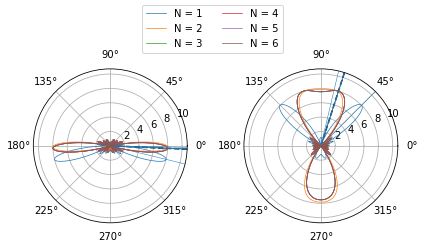

In [105]:
steer_theta = 2*np.pi * 80/360
steer_phi = 2*np.pi * 70/360

#steer_theta , steer_phi = [0.1025142957443383, 0.15520102232531016]
#steer_theta , steer_phi = [1.057276385139955, 1.7933227887316683]
steer_theta , steer_phi = [1.87842142, 1.61635823]
#N=7

fig, axes = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': 'polar'})
fig.tight_layout()

# Calculate the phase shifts for the desired steering angle using NumPy
beta_x = -k*dx*np.sin(steer_theta)*np.cos(steer_phi)
beta_y = -k*dy*np.sin(steer_theta)*np.sin(steer_phi)

# Calculate the partial array factors in the x- and y-directions
S_xm = [get_S_xm(theta, phi_x, Nx, Wx, k, dx, beta_x) for theta in thetas]
S_yn = [get_S_yn(theta, phi_y, Nx, Wx, k, dx, beta_y) for theta in thetas]

# Get beam stats. Only the estimated steering angle is interesting here.
x_stats = ar.beam_stats(np.abs(S_xm), thetas, symmetry_angle=90)
y_stats = ar.beam_stats(np.abs(S_yn), thetas, symmetry_angle=90)

x_angle_ref = x_stats["steering_angle"]
y_angle_ref = y_stats["steering_angle"]

if x_angle_ref < 0:
    x_angle_ref += 2*np.pi
elif x_angle_ref > 2*np.pi:
    x_angle_ref -= 2*np.pi

if y_angle_ref < 0:
    y_angle_ref += 2*np.pi
elif y_angle_ref > 2*np.pi:
    y_angle_ref -= 2*np.pi

axes[0].axvline(x_angle_ref, linestyle='--', color='black', linewidth=1.5)
axes[1].axvline(y_angle_ref, linestyle='--', color='black', linewidth=1.5)

for N in n_terms:
    # Calculate the phase shifts for the desired steering angle using taylor expansions
    beta_x = -k*dx*ar.sin_taylor(steer_theta, N)*ar.cos_taylor(steer_phi, N)
    beta_y = -k*dy*ar.sin_taylor(steer_theta, N)*ar.sin_taylor(steer_phi, N)

    # Calculate the partial array factors in the x- and y-directions
    S_xm = [get_S_xm(theta, phi_x, Nx, Wx, k, dx, beta_x) for theta in thetas]
    S_yn = [get_S_yn(theta, phi_y, Nx, Wx, k, dx, beta_y) for theta in thetas]

    # Visualize the array factors
    axes[0].plot(thetas, np.abs(S_xm), linewidth=0.7, label=f"N = {N}")
    axes[1].plot(thetas, np.abs(S_yn), linewidth=0.7)

    # Zero indexes that are more than 90 degrees from the baseline steering direction 
    # to eliminate backlobes aligned closely to endfire
    for i in range(len(thetas)):
        angle = thetas[i] if thetas[i] >=0 else thetas[i]+2*np.pi
        if np.abs(angle - x_angle_ref) > np.pi/2 and np.abs(angle - x_angle_ref) < np.pi*3/2:
            S_xm[i] = 4
        if np.abs(angle - y_angle_ref) > np.pi/2 and np.abs(angle - y_angle_ref) < np.pi*3/2:
            S_yn[i] = 4

    # Find the realized steering angles in the x and y directions
    x_stats = ar.beam_stats(np.abs(S_xm), thetas, symmetry_angle=90)
    y_stats = ar.beam_stats(np.abs(S_yn), thetas, symmetry_angle=90)
    
    # Add realized steering angles to plots
    axes[0].axvline(x_stats["steering_angle"], linewidth=0.5)
    axes[1].axvline(y_stats["steering_angle"], linewidth=0.5)

    x_angle = x_stats["steering_angle"]
    if x_angle < 0:
        x_angle += 2*np.pi
    elif x_angle > 2*np.pi:
        x_angle -= 2*np.pi
    y_angle = y_stats["steering_angle"]
    if y_angle < 0:
        y_angle += 2*np.pi
    elif y_angle > 2*np.pi:
        y_angle -= 2*np.pi

    x_angle_error = np.abs(x_angle - x_angle_ref)
    #if x_angle_error > np.pi:
    #    x_angle_error = 2*np.pi - x_angle_error
    y_angle_error = np.abs(y_angle - y_angle_ref)
    #if y_angle_error > np.pi:
    #    y_angle_error = 2*np.pi - y_angle_error

    print(f"x angle error (N = {N}): {x_angle_error}")
    print(f"y angle error (N = {N}): {y_angle_error}")


print(x_angle_ref)
print(y_angle_ref)

fig.legend(ncol=2, loc="upper center")
fig.savefig("./Report/My_figures/steering_error_estimation", dpi=300, 
            transparent=False, facecolor="white", 
            bbox_inches="tight")

In [90]:
#
# Perform an experiment where the steering error of a rectangular phased array antenna is estimated 
# when using taylor approximations of sine and cosine with varying numbers of terms
# for calculating the phase shifts of the antenna array. The desired steering angles
# are slightly randomized to avoid systematic patterns.
#

max_steering_errors_x = np.zeros(N_terms_max)
max_steering_errors_y = np.zeros(N_terms_max)

theta_range = max_theta_steering - min_theta_steering
phi_range = max_phi_steering - min_phi_steering

debug_x = np.zeros((2,N_terms_max))
debug_y = np.zeros((2,N_terms_max))

for steer_theta in steer_thetas:
    for steer_phi in steer_phis:
        # Add randomization
        steer_theta = steer_theta + np.random.random()*theta_range/(2*N_theta_steering_angles)
        steer_phi = steer_phi + np.random.random()*phi_range/(2*N_phi_steering_angles)
        
        # Contain steering angles within the desired range
        if steer_theta > max_theta_steering:
            steer_theta -= 2*np.abs(steer_theta - max_theta_steering)
        elif steer_theta < min_theta_steering:
            steer_theta += 2*np.abs(steer_theta - min_theta_steering)
        if steer_phi > max_phi_steering:
            steer_phi - 2*np.abs(steer_theta - max_phi_steering)
        elif steer_phi < min_phi_steering:
            steer_phi - 2*np.abs(steer_theta - min_phi_steering)



        # Calculate the phase shifts for the desired steering angle using NumPy
        beta_x = -k*dx*np.sin(steer_theta)*np.cos(steer_phi)
        beta_y = -k*dy*np.sin(steer_theta)*np.sin(steer_phi)

        # Calculate the partial array factors in the x- and y-directions
        S_xm = [get_S_xm(theta, phi_x, Nx, Wx, k, dx, beta_x) for theta in thetas]
        S_yn = [get_S_yn(theta, phi_y, Nx, Wx, k, dx, beta_y) for theta in thetas]

        # Get beam stats. Only the estimated steering angle is interesting here.
        x_stats = ar.beam_stats(np.abs(S_xm), thetas, symmetry_angle=90)
        y_stats = ar.beam_stats(np.abs(S_yn), thetas, symmetry_angle=90)

        # Estimate the realized steering angles in x and y directions 
        # when using NumPy as reference implementation
        x_angle_ref = x_stats["steering_angle"]
        y_angle_ref = y_stats["steering_angle"]

        # Contain reference steering angles within 0 - 2*pi
        if x_angle_ref < 0:
            x_angle_ref += 2*np.pi
        elif x_angle_ref > 2*np.pi:
            x_angle_ref -= 2*np.pi
        if y_angle_ref < 0:
            y_angle_ref += 2*np.pi
        elif y_angle_ref > 2*np.pi:
            y_angle_ref -= 2*np.pi

        # Calculate phase shifts and array factors, and estimate realized steering angles
        # when using the Taylor approximations
        for N in n_terms:  
            # Calculate the phase shifts for the desired steering angle using taylor expansions
            beta_x = -k*dx*ar.sin_taylor(steer_theta, N)*ar.cos_taylor(steer_phi, N)
            beta_y = -k*dy*ar.sin_taylor(steer_theta, N)*ar.sin_taylor(steer_phi, N)

            # Calculate the partial array factors in the x- and y-directions
            S_xm = [get_S_xm(theta, phi_x, Nx, Wx, k, dx, beta_x) for theta in thetas]
            S_yn = [get_S_yn(theta, phi_y, Nx, Wx, k, dx, beta_y) for theta in thetas]

            

            # Zero indexes that are more than 90 degrees from the baseline steering direction 
            # to eliminate backlobes aligned closely to endfire
            for i in range(len(thetas)):
                angle = thetas[i] if thetas[i] >=0 else thetas[i]+2*np.pi
                if np.abs(angle - x_angle_ref) > np.pi/2 and np.abs(angle - x_angle_ref) < np.pi*3/2:
                    S_xm[i] = 4
                if np.abs(angle - y_angle_ref) > np.pi/2 and np.abs(angle - y_angle_ref) < np.pi*3/2:
                    S_yn[i] = 4

            # Visualize the array factors
            #axes[0].plot(thetas, np.abs(S_xm))
            #axes[1].plot(thetas, np.abs(S_yn))

            # Find the realized steering angles in the x and y directions
            x_stats = ar.beam_stats(np.abs(S_xm), thetas, symmetry_angle=90)
            y_stats = ar.beam_stats(np.abs(S_yn), thetas, symmetry_angle=90)
            x_angle = x_stats["steering_angle"]
            y_angle = y_stats["steering_angle"]
            
            # Add realized steering angles to plots
            #axes[0].axvline(x_stats["steering_angle"], linewidth=0.5)
            #axes[1].axvline(y_stats["steering_angle"], linewidth=0.5)

            # Confine the estimated steering angles within 0 - 2*pi
            if x_angle < 0:
                x_angle += 2*np.pi
            elif x_angle > 2*np.pi:
                x_angle -= 2*np.pi
            if y_angle < 0:
                y_angle += 2*np.pi
            elif y_angle > 2*np.pi:
                y_angle -= 2*np.pi

            # Estimate the steering error in x and y directions
            x_angle_error = np.abs(x_angle - x_angle_ref)
            y_angle_error = np.abs(y_angle - y_angle_ref)

            # Confine steering error to 0 - pi 
            # (e.g. a 300 deg. error is equivalent to a 60 deg. error)
            if x_angle_error > np.pi:
                x_angle_error = 2*np.pi - x_angle_error
            if y_angle_error > np.pi:
                y_angle_error = 2*np.pi - y_angle_error
            
            # Note the steering error if it is bigger than the previously found error
            # with the same number of terms in the Taylor approximation
            if x_angle_error > max_steering_errors_x[N]:
                max_steering_errors_x[N] = x_angle_error 
                debug_x[:,N] = [steer_theta, steer_phi]
            if y_angle_error > max_steering_errors_y[N]:
                max_steering_errors_y[N] = y_angle_error
                debug_y[:,N] = [steer_theta, steer_phi]

# Print results
deg = u"\N{DEGREE SIGN}"
for N in n_terms:
    print(f"Max error in x direction (N = {N}): {max_steering_errors_x[N]*360/(2*np.pi):.3f}{deg}")
    print(f"Max error in y direction (N = {N}): {max_steering_errors_y[N]*360/(2*np.pi):.3f}{deg}")

#print(f"max_steering_errors_x: {max_steering_errors_x}")
#print(f"max_steering_errors_y: {max_steering_errors_y}")

#print(f"debug_x: {debug_x}")
#print(f"dbug_y: {debug_y}")


Max error in x direction (N = 1): 89.937°
Max error in y direction (N = 1): 70.299°
Max error in x direction (N = 2): 89.812°
Max error in y direction (N = 2): 61.042°
Max error in x direction (N = 3): 86.185°
Max error in y direction (N = 3): 10.757°
Max error in x direction (N = 4): 12.008°
Max error in y direction (N = 4): 1.251°
Max error in x direction (N = 5): 1.001°
Max error in y direction (N = 5): 0.125°
Max error in x direction (N = 6): 0.375°
Max error in y direction (N = 6): 0.125°


In [65]:
#  This code cell is a backup
max_steering_errors_x = np.zeros(N_terms_max)
max_steering_errors_y = np.zeros(N_terms_max)

theta_range = max_theta_steering - min_theta_steering
phi_range = max_phi_steering - min_phi_steering

debug_x = np.zeros((2,N_terms_max))
debug_y = np.zeros((2,N_terms_max))

for steer_theta in steer_thetas:
    for steer_phi in steer_phis:
        steer_theta = steer_theta + np.random.random()*theta_range/(2*N_theta_steering_angles)
        steer_phi = steer_phi + np.random.random()*phi_range/(2*N_phi_steering_angles)

        # Calculate the phase shifts for the desired steering angle using NumPy
        beta_x = -k*dx*np.sin(steer_theta)*np.cos(steer_phi)
        beta_y = -k*dy*np.sin(steer_theta)*np.sin(steer_phi)

        # Calculate the partial array factors in the x- and y-directions
        S_xm = [get_S_xm(theta, phi_x, Nx, Wx, k, dx, beta_x) for theta in thetas]
        S_yn = [get_S_yn(theta, phi_y, Nx, Wx, k, dx, beta_y) for theta in thetas]

        # Get beam stats. Only the estimated steering angle is interesting here.
        x_stats = ar.beam_stats(np.abs(S_xm), thetas, symmetry_angle=90)
        y_stats = ar.beam_stats(np.abs(S_yn), thetas, symmetry_angle=90)

        x_angle_ref = x_stats["steering_angle"]
        if x_angle_ref < 0:
            x_angle_ref += 2*np.pi
        elif x_angle_ref > 2*np.pi:
            x_angle_ref -= 2*np.pi
        y_angle_ref = y_stats["steering_angle"]
        if y_angle_ref < 0:
            y_angle_ref += 2*np.pi
        elif y_angle_ref > 2*np.pi:
            y_angle_ref -= 2*np.pi

        for N in n_terms:  
            # Calculate the phase shifts for the desired steering angle using taylor expansions
            beta_x = -k*dx*ar.sin_taylor(steer_theta, N)*ar.cos_taylor(steer_phi, N)
            beta_y = -k*dy*ar.sin_taylor(steer_theta, N)*ar.sin_taylor(steer_phi, N)

            # Calculate the partial array factors in the x- and y-directions
            S_xm = [get_S_xm(theta, phi_x, Nx, Wx, k, dx, beta_x) for theta in thetas]
            S_yn = [get_S_yn(theta, phi_y, Nx, Wx, k, dx, beta_y) for theta in thetas]

            # Zero indexes that are more than 90 degrees from the baseline steering direction 
            # to eliminate backlobes aligned closely to endfire
            for i in range(len(thetas)):
                angle = thetas[i] if thetas[i] >=0 else thetas[i]+2*np.pi
                if np.abs(angle - x_angle_ref) > np.pi/2 and np.abs(angle - x_angle_ref) < np.pi*3/2:
                    S_xm[i] = 0
                if np.abs(angle - y_angle_ref) > np.pi/2 and np.abs(angle - y_angle_ref) < np.pi*3/2:
                    S_yn[i] = 0

            # Get beam stats. Only the estimated steering angle is interesting here.
            x_stats = ar.beam_stats(np.abs(S_xm), thetas)
            y_stats = ar.beam_stats(np.abs(S_yn), thetas)

            x_angle = x_stats["steering_angle"]
            if x_angle < 0:
                x_angle += 2*np.pi
            elif x_angle > 2*np.pi:
                x_angle -= 2*np.pi
            y_angle = y_stats["steering_angle"]
            if y_angle < 0:
                y_angle += 2*np.pi
            elif y_angle > 2*np.pi:
                y_angle -= 2*np.pi

            x_angle_error = np.abs(x_angle - x_angle_ref)
            #if x_angle_error > np.pi:
            #    x_angle_error = 2*np.pi - x_angle_error

            y_angle_error = np.abs(y_angle - y_angle_ref)
            #if y_angle_error > np.pi:
            #    y_angle_error = 2*np.pi - y_angle_error

            

            if x_angle_error > max_steering_errors_x[N]:
                max_steering_errors_x[N] = x_angle_error 
                debug_x[:,N] = [steer_theta, steer_phi]
            if y_angle_error > max_steering_errors_y[N]:
                max_steering_errors_y[N] = y_angle_error
                debug_y[:,N] = [steer_theta, steer_phi]

print(f"max_steering_errors_x: {max_steering_errors_x}")
print(f"max_steering_errors_y: {max_steering_errors_y}")

print(f"debug_x: {debug_x}")
print(f"dbug_y: {debug_y}")


max_steering_errors_x: [0.         6.01902081 6.21987316 6.19367502 6.19804138 6.19804138]
max_steering_errors_y: [0.         1.47801128 1.23349538 1.25532715 1.25532715 1.25532715]
debug_x: [[0.         0.3832625  1.87842142 1.87842142 1.87842142 1.87842142]
 [0.         1.74959721 1.61635823 1.61635823 1.61635823 1.61635823]]
dbug_y: [[0.         1.85589033 1.85589033 1.85589033 1.85589033 1.85589033]
 [0.         1.00412378 1.00412378 1.00412378 1.00412378 1.00412378]]
